In [2]:
import torch
import numpy as np

In [3]:
import sys
import struct
import numpy as np
import sklearn
from sklearn import preprocessing
def readChoirData(dir,data_path, data_type):

    filename = dir + data_path + "_" + data_type + ".choir_dat"
    param = dict()

    with open(filename, 'rb') as f:
        nFeatures = struct.unpack('i', f.read(4))[0]
        nClasses = struct.unpack('i', f.read(4))[0]
        X = []
        y = []
        while True:
            newDP = []
            for i in range(nFeatures):
                v_in_bytes = f.read(4)
                if v_in_bytes is None or len(v_in_bytes) == 0:
                    # TODO very unprofessionally normalizing data
                    X = preprocessing.normalize(np.asarray(X), norm='l2')
                    param["nFeatures"], param["nClasses"], param["data"], param["labels"] = \
                        nFeatures, nClasses, X, np.asarray(y)
                    return param
                v = struct.unpack('f', v_in_bytes)[0]
                newDP.append(v)
            l = struct.unpack('i', f.read(4))[0]
            X.append(newDP)
            y.append(l)

In [4]:
train_data  = readChoirData('../isolet/','isolet', 'train')
test_data= readChoirData('../isolet/','isolet', 'test')

In [5]:
class HDC_Model ( object ) :
    '''Hyperdimensional classification module . Arguments :
        * dimension ( int , > 0) : The dimensionality of the high dimensional representation .
        * classes ( int , > 0) : The number of classes of the problem .
        * input_features ( int , > 0) : Dimensionality of original data .
        * probability_distribution ( string ) : Probability distribution being used .←-
            For now , it can be Uniform , Gaussian , or Laplacian .
        * act_func ( string ) : Activation function being used . For now , it can be ←-
            tanh , sin cos , or None 
    '''
    def __init__ (self, classes: int, input_features: int , probability_distribution : str, act_func:str, dimension= 4000):
        self.classes = classes
        self.input_features = input_features
        self.dimension = dimension
        self.probability_distribution = probability_distribution
        self.act_func = act_func
        self.basis = self.generate_basis()
        self.class_hypervector = torch.zeros((classes,dimension))
        self.cos = torch.nn.CosineSimilarity()
        
    def generate_basis(self):
        size = (self.input_features,self.dimension)
        if self.probability_distribution == 'Uniform':
            return torch.empty(size).uniform_(-1,1)
    
        elif self.probability_distribution == 'Gaussian':
            return np.random.normal(0,1,size)
        
        elif self.probability_distribution == 'Laplacian':
             return np.random.laplace(0,1,size=size)
        else:
            raise "Probability distribution error"
    
    def encode(self, input: torch.Tensor):
        matmul_result = torch.matmul(torch.tensor(input,dtype=float), torch.tensor(self.basis,dtype=float))
        if self.act_func == 'tanh':
            return torch.tanh(matmul_result)
        elif self.act_func == 'sin cos':
            return torch.sin(matmul_result) * torch.cos(matmul_result)
        else:
            return matmul_result
    
    def train(self,train_set, epochs:int):
        for e in range(epochs):
            for x,y in train_set:
                self.class_hypervector[y] += self.encode(torch.Tensor(x))
    
    def predict(self,data:torch.Tensor):
        given_d = self.encode(data)
        return np.argmax(self.cos(self.class_hypervector,given_d))
    
    #validation 
    def retrain(self,train_set, epochs: int):
        for e in range(epochs):
            for x,y in train_set:
                pred = self.predict(x)
                if pred ==y:
                    pass
                else:
                    hv = self.encode(x)
                    self.class_hypervector[pred] -= hv
                    self.class_hypervector[y] += hv
        return 

## Comparison between training one time vs re-training

### one-time training 

In [42]:
p = 'Uniform'
a = 'tanh'
d = 4000
hdc = HDC_Model(train_data['nClasses'],train_data['nFeatures'], probability_distribution=p,act_func=a,dimension=d)
hdc.train(zip(train_data['data'],train_data['labels']),1)
i = 0
for data,label in zip(train_data['data'],train_data['labels']):
    if hdc.predict(data) == label:
        i += 1 
acc  = i / len(train_data["data"])
print (f"Accuracy {acc}")

/var/folders/7b/5019l7l91yx79z61_pkr9gsm0000gn/T/ipykernel_74684/1069552922.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  matmul_result = torch.matmul(torch.tensor(input,dtype=float), torch.tensor(hdc.basis,dtype=float))


Accuracy 0.879127925617185


### Retraining the model

In [43]:
hdc.retrain(zip(train_data['data'],train_data['labels']),1)
i = 0
for data,label in zip(train_data['data'],train_data['labels']):
    if hdc.predict(data) == label:
        i += 1 
acc  = i / len(train_data["data"])
print (f"Accuracy {acc}")

/var/folders/7b/5019l7l91yx79z61_pkr9gsm0000gn/T/ipykernel_74684/1069552922.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  matmul_result = torch.matmul(torch.tensor(input,dtype=float), torch.tensor(hdc.basis,dtype=float))


Accuracy 0.9222507213850594


In [8]:
pd = ['Uniform','Gaussian','Laplacian']
activation = ['tanh','sin cos','']
dimensions = range(1000,7000,1000)
total_acc = {} 
for p in pd:
    for a in activation:
        for d in dimensions:
            print(f"Probability Distribution : {p}, Activation : {a}, Dimension: {d}")
            hdc = HDC_Model(train_data['nClasses'],train_data['nFeatures'], probability_distribution=p,act_func=a,dimension=d)
            hdc.train(zip(train_data['data'],train_data['labels']),1)
            i = 0
            for data,label in zip(train_data['data'],train_data['labels']):
                if hdc.predict(data) == label:
                    i += 1 
            acc  = i / len(train_data["data"])
            print (f"Accuracy {acc}")
            total_acc[(p,a,d)] = acc

Probability Distribution : Uniform, Activation : tanh, Dimension: 1000


/var/folders/7b/5019l7l91yx79z61_pkr9gsm0000gn/T/ipykernel_79047/1069552922.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  matmul_result = torch.matmul(torch.tensor(input,dtype=float), torch.tensor(hdc.basis,dtype=float))


Accuracy 0.868868226995832
Probability Distribution : Uniform, Activation : tanh, Dimension: 2000
Accuracy 0.874639307470343
Probability Distribution : Uniform, Activation : tanh, Dimension: 3000
Accuracy 0.8780057710804745
Probability Distribution : Uniform, Activation : tanh, Dimension: 4000
Accuracy 0.8797691567810195
Probability Distribution : Uniform, Activation : tanh, Dimension: 5000
Accuracy 0.875120230843219
Probability Distribution : Uniform, Activation : sin cos, Dimension: 1000
Accuracy 0.8759217697980122
Probability Distribution : Uniform, Activation : sin cos, Dimension: 2000
Accuracy 0.8756011542160949
Probability Distribution : Uniform, Activation : sin cos, Dimension: 3000
Accuracy 0.8805706957358128
Probability Distribution : Uniform, Activation : sin cos, Dimension: 4000
Accuracy 0.8805706957358128
Probability Distribution : Uniform, Activation : sin cos, Dimension: 5000
Accuracy 0.8804103879448542
Probability Distribution : Uniform, Activation : , Dimension: 1000
Ac

In [9]:
pd = ['Uniform','Gaussian','Laplacian']
activation = ['tanh','sin cos','']
d = 6000

for p in pd:
    for a in activation:
        print(f"Probability Distribution : {p}, Activation : {a}, Dimension: {d}")
        hdc = HDC_Model(train_data['nClasses'],train_data['nFeatures'], probability_distribution=p,act_func=a,dimension=d)
        hdc.train(zip(train_data['data'],train_data['labels']),1)
        i = 0
        for data,label in zip(train_data['data'],train_data['labels']):
            if hdc.predict(data) == label:
                i += 1 
        acc  = i / len(train_data["data"])
        print (f"Accuracy {acc}")
        total_acc[(p,a,d)] = acc

Probability Distribution : Uniform, Activation : tanh, Dimension: 6000


/var/folders/7b/5019l7l91yx79z61_pkr9gsm0000gn/T/ipykernel_79047/1069552922.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  matmul_result = torch.matmul(torch.tensor(input,dtype=float), torch.tensor(hdc.basis,dtype=float))


Accuracy 0.8744789996793845
Probability Distribution : Uniform, Activation : sin cos, Dimension: 6000
Accuracy 0.8832959281821097
Probability Distribution : Uniform, Activation : , Dimension: 6000
Accuracy 0.8784866944533505
Probability Distribution : Gaussian, Activation : tanh, Dimension: 6000
Accuracy 0.879127925617185
Probability Distribution : Gaussian, Activation : sin cos, Dimension: 6000
Accuracy 0.8970823982045527
Probability Distribution : Gaussian, Activation : , Dimension: 6000
Accuracy 0.8752805386341777
Probability Distribution : Laplacian, Activation : tanh, Dimension: 6000
Accuracy 0.8832959281821097
Probability Distribution : Laplacian, Activation : sin cos, Dimension: 6000
Accuracy 0.9155177941647964
Probability Distribution : Laplacian, Activation : , Dimension: 6000
Accuracy 0.874639307470343


In [29]:
# dimension 
probability = 'Uniform'
activation = 'sin cos'
result = []
for k in total_acc:
    if k[0] == probability:
        if k[1] == activation:
            result.append((k[2],total_acc[k]))

In [39]:
(probability,activation,1000)

('Uniform', 'sin cos', 1000)

In [57]:
result_df = pd.DataFrame(columns= ['prob','act','dim','acc'])

for k in total_acc:Mresult_df.append({'prob':k[0],'act':k[1],'dim':k[2],'acc':total_acc[k]},ignore_index=True )

In [64]:
result_df

,prob,act,dim,acc
0,Uniform,tanh,1000,0.868868
1,Uniform,tanh,2000,0.874639
2,Uniform,tanh,3000,0.878006
3,Uniform,tanh,4000,0.879769
4,Uniform,tanh,5000,0.875120
5,Uniform,sin cos,1000,0.875922
6,Uniform,sin cos,2000,0.875601
7,Uniform,sin cos,3000,0.880571
8,Uniform,sin cos,4000,0.880571
9,Uniform,sin cos,5000,0.880410


### Comparisons of different hyperparameters 

- tanh activation

<AxesSubplot:xlabel='dim'>

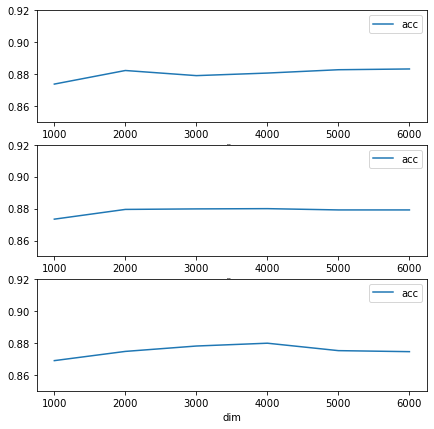

In [99]:
fig,ax = plt.subplots(3,1,figsize=(7,7))
ax[0].set_ylim([0.85,0.92])
ax[1].set_ylim([0.85,0.92])
ax[2].set_ylim([0.85,0.92])
result_df[(result_df['prob']=='Laplacian') & (result_df['act']=='tanh')][['dim','acc']].plot(x='dim',y='acc',ax=ax[0])
result_df[(result_df['prob']=='Gaussian') & (result_df['act']=='tanh')][['dim','acc']].plot(x='dim',y='acc',ax=ax[1])
result_df[(result_df['prob']=='Uniform') & (result_df['act']=='tanh')][['dim','acc']].plot(x='dim',y='acc',ax=ax[2])

- sin cos activation

<AxesSubplot:xlabel='dim'>

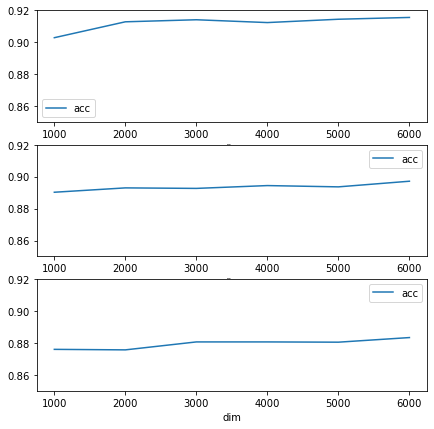

In [100]:
fig,ax = plt.subplots(3,1,figsize=(7,7))
ax[0].set_ylim([0.85,0.92])
ax[1].set_ylim([0.85,0.92])
ax[2].set_ylim([0.85,0.92])
result_df[(result_df['prob']=='Laplacian') & (result_df['act']=='sin cos')][['dim','acc']].plot(x='dim',y='acc',ax=ax[0])
result_df[(result_df['prob']=='Gaussian') & (result_df['act']=='sin cos')][['dim','acc']].plot(x='dim',y='acc',ax=ax[1])
result_df[(result_df['prob']=='Uniform') & (result_df['act']=='sin cos')][['dim','acc']].plot(x='dim',y='acc',ax=ax[2])

- None activation

<AxesSubplot:xlabel='dim'>

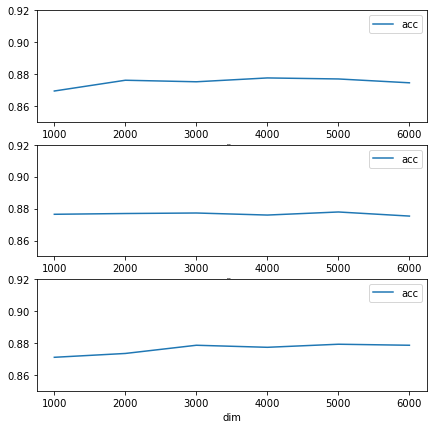

In [101]:
fig,ax = plt.subplots(3,1,figsize=(7,7))
ax[0].set_ylim([0.85,0.92])
ax[1].set_ylim([0.85,0.92])
ax[2].set_ylim([0.85,0.92])
result_df[(result_df['prob']=='Laplacian') & (result_df['act']=='')][['dim','acc']].plot(x='dim',y='acc',ax=ax[0])
result_df[(result_df['prob']=='Gaussian') & (result_df['act']=='')][['dim','acc']].plot(x='dim',y='acc',ax=ax[1])
result_df[(result_df['prob']=='Uniform') & (result_df['act']=='')][['dim','acc']].plot(x='dim',y='acc',ax=ax[2])